In [3]:
from selenium import webdriver as wd
import urllib

In [4]:
driver = wd.Chrome('../tool/chromedriver_75.0.3770.140.exe')

In [5]:
target_url = 'http://www.opinet.co.kr/searRgSelect.do'

In [6]:
# 해당사이트가 중간 페이지를 직접 접속하는 부분을 거부하기 때문에 
# 시간차를 두고 2회 요청을 진행했다
import time
for n in range(2):
    driver.get( target_url )
    time.sleep(5)

- 1. 시도 정보를 추출하여 리스트화
- 2. 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
- 3. 시군구 리스트를 반복하면서 읍면동 리스트화
- 4. 읍면동 리스트를 반복하면서 -> 조회 -> 다운로드 순으로 진행되는것이 기본
- 5. 사이트 관찰 결과, 시도, 시군구, 읍면동 정보가 새로 세팅되면 화면의 DOM이 모두 새로구성이 되는 문제가 있어서 반복문 안에서는 반드시 시도, 시군구, 읍면동을 새로 잡아줘야한다!!(매우중요)
- 6. 시군구를 반복하면서 바로 조회 및 다운로드로 전개하겟다(여기서는)

In [7]:
# 시도 리스트 획득
sidos = [ option.get_attribute('value') 
          for option in driver.find_elements_by_css_selector('#SIDO_NM0 > option') 
          if option.get_attribute('value') 
        ]
# 데이터의 상위값, 하위값 조사를 통해 샘플링으로 확인
sidos[:2], sidos[-2:],sidos[1:2]

(['서울특별시', '부산광역시'], ['경상남도', '제주특별자치도'], ['부산광역시'])

In [8]:
# 2. 시도 리스트를 반복하면서 해당 시도 밑에 시군구 리스트화
# sidos 중에 부산만 대상으로 수집하겟다
for sido in sidos[1:2]:
    # 2-1. sido 대상 찾아서
    sido_tag = driver.find_element_by_id('SIDO_NM0')
    # 2-2. sido 값을 설정
    sido_tag.send_keys( sido )
    # 2-2-2. 잠시대기(ajax 통신후 화면이 재구성될대까지)
    time.sleep(6)
    # 2-3. 시군구 리스트 획득
    sigungos = [ option.get_attribute('value') 
        for option in driver.find_elements_by_css_selector('#SIGUNGU_NM0 > option') 
        if option.get_attribute('value') 
    ]
    print( sido, sigungos[:2] )
    # 2-4. 반복~ 3단계로 진입
    # 3. 시군구 리스트를 반복하면서 ->  잠시대기(5초대기) -> 엑셀저장
    for sigungo in sigungos:
        # 3-1. 시군구 태그를 찾아서
        sigungo_tag = driver.find_element_by_id('SIGUNGU_NM0')
        # 3-2. 시군구값 설정
        sigungo_tag.send_keys( sigungo )
        # 3-3. 잠시 대기
        time.sleep(5)
        # 3-4. 엑셀 저장
        driver.find_element_by_id('glopopd_excel').click()

부산광역시 ['강서구', '금정구']


### 데이터 수집 완료

- 수십개의 엑셀 파일을 반복적으로 읽어서 DataFrame으로 구성하기

In [94]:
# glob 특정 위치상에 존재하는 파일들을 패턴을 지정하여 목록을 구할수 있다
from glob import glob
import pandas as pd

In [95]:
# 부산관한 시군구에 조회된 엑셀 자료를 읽을 수 있게 파일 경로를 리스트화
down_files = glob('C:/Users/User/Downloads/지역*.xls')
down_files[:2],down_files[-2:]

(['C:/Users/User/Downloads\\지역_위치별(주유소) (1).xls',
  'C:/Users/User/Downloads\\지역_위치별(주유소) (10).xls'],
 ['C:/Users/User/Downloads\\지역_위치별(주유소) (9).xls',
  'C:/Users/User/Downloads\\지역_위치별(주유소).xls'])

In [96]:
# 그냥 참고만(아직 배우기전)
# conda install xlrd
tmp_raws = []
for file in down_files:
    tmp = pd.read_excel( file, header=2 )
    tmp_raws.append( tmp )
# 여기는 데이터 확인차!! 
st_raw = pd.concat( tmp_raws )

In [97]:
st_raw.shape

(422, 10)

In [98]:
st_raw.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-


In [99]:
st_raw.tail(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
47,부산광역시,SK에너지(주)새부산주유소,부산 강서구 낙동북로 42 (강동동),SK에너지,051-971-8484,N,-,1543,1413,-
48,부산광역시,은마석유(주) 구랑주유소,부산 강서구 가락대로 546 (구랑동),GS칼텍스,051-972-1571,Y,-,-,1278,-


- 응용 : 시군구 단위 => 읍면동 단위
> 1. 주유소정보데이터 부산시 행정구역으로 표현  
> 2. 자치구별 가장 저렴한 주유소 및 가장 비싼 주유소 마킹  
> 3. 행정구역별 주유가격 평균을 통해서 칼라맵으로 표시, 휘발유기준, 가격없는 주유소는 배제  
> 4. 브랜드별(6개) 알뜰주유소 Vs 브랜드대비, 진짜 싼지 체크!!  -> seaborn의 박스플롯과 스완플롯을 같이 활용하여 시각화 한다
> 브랜드, 셀프여부, 휘발유/경유,등등

In [100]:
# 주소가 xx동이 탐색되는 있는 주유소 정보
tmp = st_raw[ st_raw['주소'].apply( lambda x: x.find('동)')<0 ) ]
tmp.shape

(121, 10)

In [101]:
# 값 중볷성 제거를 통한 결측치 및 타입 확인
st_raw['휘발유'].unique()

array([1438, 1442, 1443, 1455, 1458, 1463, 1468, 1483, 1488, 1497, 1498,
       1529, 1539, 1540, 1577, 1665, 1440, 1448, 1473, 1478, 1548, 1437,
       1477, 1485, 1493, 1495, 1547, 1620, 1638, 1648, 1453, 1465, 1470,
       1482, 1489, 1518, 1519, 1598, 1628, 1644, 1408, 1565, 1427, 1434,
       1435, 1445, 1447, 1469, 1474, 1475, 1480, 1503, 1505, 1510, 1523,
       1553, 1563, 1613, 1459, 1479, 1487, 1490, 1545, 1649, 1419, 1420,
       1424, 1457, 1467, 1499, 1513, 1538, 1549, 1569, 1585, 1446, 1508,
       1845, 1462, 1699, 1425, 1428, 1429, 1471, 1528, 1575, 1433, 1466,
       1544, 1414, 1415, 1418, 1464, 1579, 1597, 1599, 1739, '1430',
       '1447', '1448', '1452', '1458', '1463', '1468', '1478', '1487',
       '1488', '1495', '1497', '1498', '1499', '1508', '1518', '1563',
       '-', '1405', '1415', '1437', '1438', '1445', '1465', '1479',
       '1509', '1529', '1543'], dtype=object)

In [102]:
# 지도 시각화의 기준점이 휘발유가격이므로, 휘발유 가격을 정제하여 
# 의미있는 데이터만 남긴다
st_raw_price_exist = st_raw[ st_raw['휘발유'] != '-' ]
st_raw_price_exist.shape

(418, 10)

In [103]:
# 데이터 정수형으로 형변환 astype() <- 시리즈
st_raw_price_exist.loc[:, '휘발유'] = st_raw_price_exist.loc[:, '휘발유'].astype(int)

C:\Users\User\Anaconda3\envs\analysis\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [104]:
st_raw_price_exist['휘발유'].unique()

array([1438, 1442, 1443, 1455, 1458, 1463, 1468, 1483, 1488, 1497, 1498,
       1529, 1539, 1540, 1577, 1665, 1440, 1448, 1473, 1478, 1548, 1437,
       1477, 1485, 1493, 1495, 1547, 1620, 1638, 1648, 1453, 1465, 1470,
       1482, 1489, 1518, 1519, 1598, 1628, 1644, 1408, 1565, 1427, 1434,
       1435, 1445, 1447, 1469, 1474, 1475, 1480, 1503, 1505, 1510, 1523,
       1553, 1563, 1613, 1459, 1479, 1487, 1490, 1545, 1649, 1419, 1420,
       1424, 1457, 1467, 1499, 1513, 1538, 1549, 1569, 1585, 1446, 1508,
       1845, 1462, 1699, 1425, 1428, 1429, 1471, 1528, 1575, 1433, 1466,
       1544, 1414, 1415, 1418, 1464, 1579, 1597, 1599, 1739, 1430, 1452,
       1405, 1509, 1543], dtype=int64)

In [105]:
# 시리즈 타입 확인
st_raw_price_exist['휘발유'].dtype

dtype('int32')

In [106]:
st_raw_price_exist['휘발유'].min(), st_raw_price_exist['휘발유'].max(), st_raw_price_exist['휘발유'].mean()

(1405, 1845, 1476.4784688995214)

In [107]:
st_raw_price_exist.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-


In [108]:
tmp_gu = st_raw_price_exist['주소'].apply( lambda x : x.split()[1] )
st_raw_price_exist['자치구'] = tmp_gu

C:\Users\User\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
# 부산의 총 자치구 중복성 검사, 16개 확인 완료
st_raw_price_exist['자치구'].unique(), len(st_raw_price_exist['자치구'].unique())

(array(['금정구', '서구', '수영구', '연제구', '영도구', '중구', '해운대구', '기장군', '남구', '동구',
        '동래구', '부산진구', '북구', '사상구', '사하구', '강서구'], dtype=object), 16)

In [110]:
st_raw_gasoline = pd.pivot_table( st_raw_price_exist, index='자치구' )

In [111]:
st_raw_gasoline.sort_values(by='휘발유')

,휘발유
자치구,
기장군,1460.413043
북구,1466.315789
연제구,1467.235294
서구,1469.416667
사상구,1470.785714
동래구,1472.458333
사하구,1473.696970
강서구,1473.833333
부산진구,1474.458333


In [112]:
# mim, max scaler를 이용한 정규화를 통해서 가격비율 컬럼을 생성
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [113]:
x        = st_raw_gasoline.values
x_scaled = min_max_scaler.fit_transform( x.astype(float) )
x_scaled

array([[0.18595311],
       [0.33028767],
       [0.        ],
       [0.33988797],
       [0.49586827],
       [0.16690095],
       [0.19461318],
       [0.08178914],
       [0.14372494],
       [0.18406364],
       [0.12475526],
       [0.52651474],
       [0.0945299 ],
       [1.        ],
       [0.36146393],
       [0.26180647]])

In [114]:
tmp = pd.DataFrame( x_scaled, columns=['휘발유정규화'], index=st_raw_gasoline.index )

In [115]:
tmp.head(2)

,휘발유정규화
자치구,
강서구,0.185953
금정구,0.330288


In [116]:
import folium

In [117]:
gps = [ 35.1564294,129.0603389 ]

In [118]:
import json
geo_str = json.load( open( '../pandas/data/busan.json', encoding='utf-8' ) )

In [119]:
tmp.index

Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구',
       '서구', '수영구', '연제구', '영도구', '중구', '해운대구'],
      dtype='object', name='자치구')

In [120]:
tmp.columns

Index(['휘발유정규화'], dtype='object')

In [121]:
map_busan = folium.Map( location=gps, zoom_start=10)
# 행정구역을 표현
folium.Choropleth( geo_data=geo_str
                   ,name='busan'
                   ,data=tmp 
                   ,columns=[ tmp.index, '휘발유정규화' ]
                   ,key_on='feature.id'
                   ,fill_color='PuRd'
                   ,legend_name='부산시 자치구별 휘발유가격 비율'
                 ).add_to(map_busan)
map_busan

In [122]:
# 2. 자치구별 가장 저렴한 주유소 및 가장 비싼 주유소 마킹  
# 휘발유 데이터중 없는 부분 제거, 타입을 통일한 df가 
st_raw_price_exist

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-,금정구
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-,금정구
2,부산광역시,청룡명품주유소,부산 금정구 중앙대로 2130,현대오일뱅크,051-508-5150,N,-,1442,1292,-,금정구
3,부산광역시,은마석유 노포주유소,부산 금정구 중앙대로 2191 (노포동),GS칼텍스,051-508-1645,Y,-,1443,1293,1050,금정구
4,부산광역시,광신석유(주)직영경부고속주유소,부산 금정구 중앙대로1720번길 7 (부곡동),SK에너지,051-517-6011,Y,-,1455,1315,1010,금정구
5,부산광역시,한솔유화(주) 직영 한길주유소,부산 금정구 중앙대로 1646 (부곡동),현대오일뱅크,051-581-0875,N,-,1455,1315,1000,금정구
6,부산광역시,거북이주유소(SK),부산 금정구 중앙대로 1672 (부곡동),SK에너지,051-516-5151,Y,-,1455,1315,-,금정구
7,부산광역시,지에스칼텍스(주)신창주유소,부산 금정구 중앙대로 1698 (부곡동),GS칼텍스,051-581-1212,N,1730,1455,1315,990,금정구
8,부산광역시,금두꺼비주유소,부산광역시 금정구 부곡로 67 (부곡동),현대오일뱅크,051-583-6433,Y,-,1455,1315,990,금정구
9,부산광역시,금샘로주유소,부산 금정구 금샘로 460 (남산동),SK에너지,051-517-0220,Y,1655,1455,1315,-,금정구


In [123]:
# 인덱스 데이터가 수치가 중볷성이 많다
# 재 인덱스 작업 필요
st_raw_price_exist.reset_index(inplace=True)

In [124]:
# 불필요한 인덱스 컬럼이 생성되었다 => 제거
st_raw_price_exist.columns

Index(['index', '지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유',
       '실내등유', '자치구'],
      dtype='object')

In [125]:
del st_raw_price_exist['index']
st_raw_price_exist.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

In [126]:
st_raw_price_exist.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-,금정구
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-,금정구


In [127]:
# 2. 자치구별 가장 저렴한 주유소 및 가장 비싼 주유소 마킹  
# 데이터를 자치구별로 통합 -> 피벗테이블 -> 휘발유가격이 평균(X),최소,최대가 포함
# aggfunc=[min, max
# 자치구별 평균 휘발유가격 -> 부산시의 어느 자치구가 가장 휘발유가격이 저렴한지
# 바차트를 통해서 시각화 가능
pd.pivot_table( st_raw_price_exist, index='자치구')

,휘발유
자치구,
강서구,1473.833333
금정구,1484.250000
기장군,1460.413043
남구,1484.942857
동구,1496.200000
동래구,1472.458333
부산진구,1474.458333
북구,1466.315789
사상구,1470.785714


In [128]:
import numpy as np
min_max_df = pd.pivot_table( st_raw_price_exist, index='자치구', 
                             aggfunc=[np.min, np.max])
# 피벗의 결과 휘발유는 정확하다, 그외정보가 부정확하다
# 모든 컬럼에 min, max 적용이 되서 모여진 결과로 보인다

In [129]:
min_max_df.head(2)

amin                                                         \
       경유 고급휘발유     상표                상호 셀프여부 실내등유          전화번호   
자치구                                                                
강서구  1265     -  GS칼텍스  (주)DJS신항만물류단지주유소    N    -  051-208-5199   
금정구  1288     -  GS칼텍스            A1 주유소    N    -  051-508-1645   

                                          amax                               \
                         주소     지역   휘발유    경유 고급휘발유      상표        상호 셀프여부   
자치구                                                                           
강서구  부산 강서구 가락대로 1361 (봉림동)  부산광역시  1405  1413  1799  현대오일뱅크     현대주유소    Y   
금정구    부산 금정구  반송로 391 (서동)  부산광역시  1438  1535  2039  현대오일뱅크  훼미리알뜰주유소    Y   

                                                                
    실내등유           전화번호                        주소     지역   휘발유  
자치구                                                             
강서구  950  070-4454-9235    부산광역시 강서구 호계로 200(죽동동)  부산광역시  1543  
금정구  990   051-583-8951  부산광역시 금정구 중앙대로 2044(남산동)  부산광역시  1665

In [130]:
min_max_df.shape

(16, 20)

In [131]:
# 강서구의 휘발유 가격 정렬후 확인
# 강서구 데이터만 추출 -> 정렬(휘발유 기준)
# loc을 사용하시오
gs_ = st_raw_price_exist.loc[ st_raw_price_exist['자치구']=='강서구' ]
gs_.shape

(48, 11)

In [132]:
gs_.sort_values( by='휘발유' )[:1]

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
370,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1405,1265,950,강서구


In [133]:
gs_.sort_values( by='휘발유' )[-1:]

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
417,부산광역시,SK에너지(주)새부산주유소,부산 강서구 낙동북로 42 (강동동),SK에너지,051-971-8484,N,-,1543,1413,-,강서구


In [134]:
gs_.sort_values( by='휘발유' )

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
370,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1405,1265,950,강서구
371,부산광역시,유성에너지(주)풍경주유소,부산 강서구 낙동남로 432,SK에너지,051-972-9676,N,-,1415,1285,-,강서구
372,부산광역시,(주)우양네트웍스 송산주유소,부산광역시 강서구 호계로 200(죽동동),S-OIL,051-973-7583,Y,-,1437,1299,-,강서구
373,부산광역시,공항대로주유소,부산 강서구 공항로 1217 (대저1동),S-OIL,051-973-8122,Y,-,1437,1338,950,강서구
374,부산광역시,은마석유(주)신호주유소,부산광역시 강서구 낙동남로 514 (화전동),현대오일뱅크,051-971-6331,Y,-,1438,1308,1030,강서구
375,부산광역시,SC(주)국제산업물류단지 주유소,부산광역시 강서구 생곡로 272,GS칼텍스,051-714-2208,Y,-,1438,1278,950,강서구
376,부산광역시,이왕주유소,부산 강서구 대저로255번길 21 (대저1동),현대오일뱅크,051-972-9007,N,-,1438,1328,-,강서구
377,부산광역시,우담주유소,부산광역시 강서구 낙동남로 127 (송정동),S-OIL,051-973-5131,N,-,1445,1299,-,강서구
380,부산광역시,신항만주유소,부산 강서구 가락대로1243번길 68,현대오일뱅크,051-973-0935,Y,-,1448,1288,-,강서구
379,부산광역시,(주)에스피씨삼립 부산신항주유소,부산 강서구 가락대로 706 (생곡동),현대오일뱅크,051-941-5189,Y,-,1448,1288,-,강서구


In [135]:
# 피벗으로 어떻게 해서 휘발유가격만 최소, 최대로 남겨서 df를 뽑으면
min_max_df = pd.pivot_table( st_raw_price_exist, index='자치구',                             
                             aggfunc=[np.min, np.max])
#min_max_df
# -> 그 가격에 일치하는 나머지 데이터를 뽑아서 최종 최소/최대 주유소 정보를 추출!!

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [137]:
from korea_font import initKoreaFontLoad
initKoreaFontLoad()

Malgun Gothic


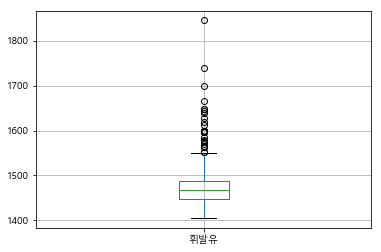

In [138]:
st_raw_price_exist.boxplot( column='휘발유' )

In [139]:
st_raw_price_exist.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

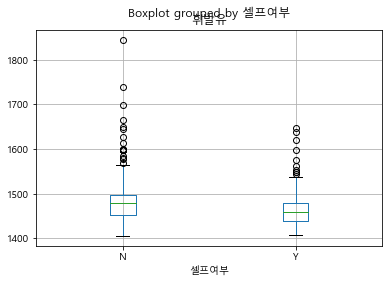

In [140]:
st_raw_price_exist.boxplot( column='휘발유', by='셀프여부' )
# 셀프주유가 일반 주유소대비 가격이 저렴하다!!
# 모든 주유소가 싼것은 아니다 일부 비싼 주유소도 존재

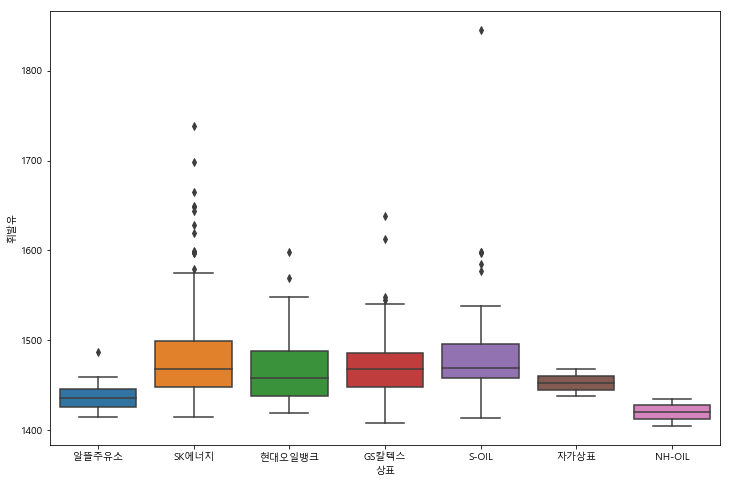

In [141]:
plt.figure( figsize=(12,8) )
sns.boxplot( x='상표', y='휘발유', data=st_raw_price_exist )
plt.show()
# 부산 지역에서 알뜰 주유소가 브랜드 주유소 대비싼가? NH를 제외하고는 평균적으로 싸다

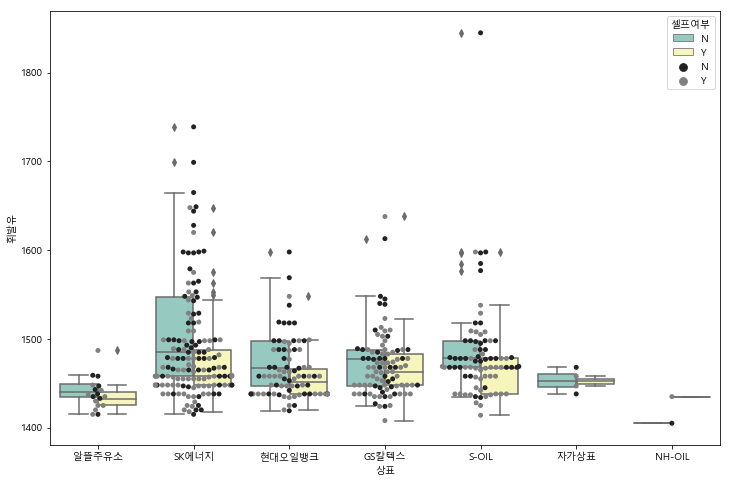

In [142]:
plt.figure( figsize=(12,8) )
sns.boxplot( x='상표', y='휘발유', hue='셀프여부', data=st_raw_price_exist, 
            palette='Set3' )
sns.swarmplot( x='상표', y='휘발유', hue='셀프여부', data=st_raw_price_exist, 
            color='.5' )
plt.show()
# 셀프 주유소는 자가상표, NH를 제외하고 모드 비셀프보다 저렴(자사브랜드대비)
# NH는 그 주유소의 수량이 너무 작아서 사실상 배제
# 알뜰 주유소가 브랜디 대비 휘발유 가격이 싸다고 주장후 잇음

In [144]:
# 알뜰 주유소는 부산 전역 모든 주유소 대비 점유율 4.3%
len( st_raw_price_exist.loc[st_raw_price_exist['상표']=='알뜰주유소'] ) / len(st_raw_price_exist) * 100

4.30622009569378

In [145]:
# 휘발유만 최소, 최대로 포함되게 처리
min_max_df = pd.pivot_table( st_raw_price_exist, 
                             index='자치구',
                             values='휘발유',
                             aggfunc=[np.min, np.max])
min_max_df.head(2)

,amin,amax
,휘발유,휘발유
자치구,,
강서구,1405,1543
금정구,1438,1665


In [146]:
min_max_df.columns

MultiIndex(levels=[['amin', 'amax'], ['휘발유']],
           labels=[[0, 1], [0, 0]])

In [147]:
st_raw_price_exist.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

In [156]:
# 최소값만 -> 숫자만 나오게 조정
# 컬럼의 뎁스가 1이 이상인 경우 한개로 통합할것인가?(1차로 갈것인가)\
# 뎁스를 유지하면서 레벨로 접근하면서 갈것인가?
tmp = list()
for idx, oil_price in enumerate(min_max_df['amin']['휘발유']):    
    # 자치구, 가격 -> 표시하고 싶다
    #print( type(min_max_df.index[idx]), oil_price )
    # st_raw_price_exist를 대상으로
    # 각 자치구를 돌면서 저 가격에 해단되는 주유소를 찾아서, 상호, 주소를 추출
    
    # 1. 검색대상을 줄이고 => 2. 그중에서 단가와 일치하는 대상을 찾는 방식
    gu  = st_raw_price_exist[ st_raw_price_exist['자치구'] == min_max_df.index[idx]]    
    row = gu[ gu['휘발유'] == oil_price  ]
    #print( row.shape, min_max_df.index[idx], oil_price )
    tmp.append( row )
    # 그래야지 => gps  획득 => 지도에 마킹이 가능
    
    # 조건 2개를 [ () & () ]로 구현하여 대상을 좁혔다
    # 모가 되었던 전체를 게속 블리언 인덱싱을 해야 하므로, 조금 비효율적    
    #row  = st_raw_price_exist[ (st_raw_price_exist['자치구'] == min_max_df.index[idx]) 
    #                           & (st_raw_price_exist['휘발유'] == oil_price) ]
    #print( row.shape, min_max_df.index[idx], oil_price )
    
    # 한덩어리로 만들어서

# 출력
pd.concat( tmp ).shape

(25, 11)

In [159]:
# 리스트 내포로 처리
pd.concat( [ 
    st_raw_price_exist[ (st_raw_price_exist['자치구'] == min_max_df.index[idx]) & (st_raw_price_exist['휘발유'] == oil_price) ]
    for idx, oil_price in enumerate(min_max_df['amin']['휘발유'])
] ).head(1)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구
370,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1405,1265,950,강서구


In [163]:
# col => 'amin', 'amax'
tmp = list()
for col in min_max_df.columns.levels[0]:
    tmp.append ( pd.concat( [ 
        st_raw_price_exist[ (st_raw_price_exist['자치구'] == min_max_df.index[idx]) & (st_raw_price_exist['휘발유'] == oil_price) ]
        for idx, oil_price in enumerate(min_max_df[col]['휘발유'])
    ] ) )
pd.concat( tmp ).shape

(43, 11)

In [164]:
# min, max를 각각  concat으로 구해서 다시 전체 2덩어리는 concat  한다
target_df = pd.concat( [
    pd.concat( [ 
        st_raw_price_exist[ (st_raw_price_exist['자치구'] == min_max_df.index[idx]) & (st_raw_price_exist['휘발유'] == oil_price) ]
        for idx, oil_price in enumerate(min_max_df[col]['휘발유'])
    ] )    
    for col in min_max_df.columns.levels[0]
] )
target_df.shape

(43, 11)

In [165]:
# 대상 주유소에 대한 df는 target_df에 모여있다
# 하나씩 빼거, gps를 완성(api를 사용)후 지도에 시각화
# 비싼 주유소는 빨강색, 싼 주유소는 파랑색 표시
# gps는 주소를 통해서 획득
target_df.columns

Index(['지역', '상호', '주소', '상표', '전화번호', '셀프여부', '고급휘발유', '휘발유', '경유', '실내등유',
       '자치구'],
      dtype='object')

In [169]:
len (target_df.index), len (target_df.index.unique())

(43, 43)

In [171]:
target_df.index

Int64Index([370,   0,   1, 123, 124, 125, 126, 127, 128, 129, 130, 169, 204,
            214, 238, 262, 281, 337,  24,  36,  53,  70,  71,  82,  84, 417,
             23, 168, 201, 202, 203, 213, 237, 261, 280, 336, 369,  35,  52,
             69,  81,  83, 122],
           dtype='int64')

In [183]:
import urllib, json
API_KEY = 'e34bb81e2e35e85ca6efee410badd670'
url     = 'https://dapi.kakao.com/v2/local/search/address.json?query={}'
def getGpsByAddr( addr ):
    try:
        tmp_url = url.format( urllib.parse.quote(addr) )
        request = urllib.request.Request( tmp_url )
        request.add_header("Authorization", 'KakaoAK {app_key}'.format(app_key=API_KEY) )
        response = urllib.request.urlopen(request)
        if(response.getcode()==200):
            tmp = json.load(response)
            y = tmp['documents'][0]['y']
            x = tmp['documents'][0]['x']
            return y, x
        else:
            return 0, 0 # 적도 좌표로 보낸다
    except Exception as e:
        print( '오류', addr)#)
        return 0,0

In [184]:
# 앞뒤 공백을 모두 제거하고 싶다
lats = list()
lngs = list()
for addr in target_df['주소'].apply( lambda x:x.strip() ):  
    print(addr)
    # 통신후 gps를 횏득
    lat, lng = getGpsByAddr( addr )
    lats.append( lat )
    lngs.append( lng )

부산 강서구 낙동남로 448 (녹산동)
부산 금정구 두실로 2 (남산동)
부산 금정구 중앙대로 1972
부산 기장군 일광면 기장대로 1230
부산 기장군 정관면 정관로 901
부산 기장군 일광면 기장대로 1291
부산 기장군 장안읍 좌동길 45
부산광역시 기장군 장안읍 좌동길 47
부산 기장군 장안읍 정관로 1115
부산 기장군 일광면 기장대로 1037
부산 기장군 기장읍 기장대로 84
부산 남구 신선로 252
부산 동구 중앙대로 352 (초량동)
부산광역시 동래구  반송로 303 (명장동)
부산 부산진구 백양대로 231
부산 북구 백양대로 995 (구포동)
부산 사상구 새벽로 154 (감전동)
부산광역시 사하구  장평로 152 (장림동)
부산 서구 보수대로 220
부산 수영구 연수로 250 (망미동)
부산 연제구 고분로 51 (연산동)
부산 영도구 태종로 782 (동삼동)
부산 영도구 태종로 806-1 (동삼동)
부산광역시 중구  중구로 194 (영주동)
부산 해운대구 석대천로 198 (반송동)
부산 강서구 낙동북로 42 (강동동)
부산 금정구 중앙대로 1756
부산 기장군 정관면 정관덕산길 21
부산 남구 황령대로98번길 75 (문현동)
오류 부산 남구 황령대로98번길 75 (문현동)
부산 남구 유엔로 42 (우암동)
부산 남구 석포로 134 (대연동)
부산 동구 중앙대로 168 (초량동)
부산 동래구 중앙대로 1371 (온천동)
부산 부산진구 전포대로176번길 5 (전포동)
오류 부산 부산진구 전포대로176번길 5 (전포동)
부산 북구 금곡대로 362 (화명동)
부산 사상구 낙동대로 1274 (삼락동)
부산 사하구 장림번영로 7 (장림동)
부산 서구 대신공원로 1 (동대신동3가)
부산 수영구 좌수영로 147 (망미동)
부산 연제구 아시아드대로 107 (거제동)
부산 영도구 태종로 181 (봉래동4가)
부산 중구 대청로 153 (중앙동5가)
부산광역시 해운대구  해운대해변로 44 (우동)


In [186]:
lats, lngs

(['35.11192073422368',
  '35.26054361552982',
  '35.26042595604724',
  '35.30293226733894',
  '35.32453791507658',
  '35.308316526904505',
  '35.321203724808235',
  '35.32151830495734',
  '35.32228003091803',
  '35.28631488776029',
  '35.20478035664164',
  '35.110374309835166',
  '35.12701999025575',
  '35.20674918407658',
  '35.1572003270461',
  '35.19443940028069',
  '35.15497001548498',
  '35.07983115849022',
  '35.114660415906535',
  '35.172999280109565',
  '35.185818519643995',
  '35.066634690918725',
  '35.06459181710939',
  '35.11174116464393',
  '35.22104400113889',
  '35.21872358487043',
  '35.24113091161727',
  '35.32320716127476',
  0,
  '35.12713355574594',
  '35.12910014730122',
  '35.11236303849652',
  '35.20960768458388',
  0,
  '35.240875870172914',
  '35.17392536312102',
  '35.08200351753661',
  '35.119566345059155',
  '35.17692566025697',
  '35.19388775901549',
  '35.09500147085103',
  '35.10314602763789',
  '35.16304477928331'],
 ['128.86853872145076',
  '129.0910841

In [187]:
target_df['위도'] = lats
target_df['경도'] = lngs

In [188]:
target_df.head(2)

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구,위도,경도
370,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1405,1265,950,강서구,35.11192073422368,128.86853872145076
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-,금정구,35.26054361552982,129.09108415788532


In [190]:
# gps 를 획득하지 못한 2개 데이터를 제거후 -> 마킹의 최종 데이터
target_df = target_df[ target_df['위도']!=0]
target_df.shape

(41, 13)

In [192]:
# 최저가들 중에서 최고값
min_max_df['amin']['휘발유'].max()
# 마킹시 휘발유 값이 1497>= 이면 마커의 칼라를 blue

1497

In [193]:
# 최고가들에서 최저값
min_max_df['amax']['휘발유'].min()
# 마킹시 휘발유 값이 1518<= 이면 마커의 칼라를 red

1518

In [204]:
tmp = pd.DataFrame( x_scaled, columns=['휘발유정규화'], index=st_raw_gasoline.index )
map_busan = folium.Map( location=gps, zoom_start=10)
# 행정구역을 표현
folium.Choropleth( geo_data=geo_str
                   ,name='busan'
                   ,data=tmp 
                   ,columns=[ tmp.index, '휘발유정규화' ]
                   ,key_on='feature.id'
                   ,fill_color='PuRd'
                   ,legend_name='부산시 자치구별 휘발유가격 비율'
                 ).add_to(map_busan)

for n in target_df.index:
    # 0. 순수한 표현
    #color = 'blue'
    #if target_df['휘발유'][n] > 1497:
    #    color = 'red'
    
    # 파이썬의 삼항연산자 대용
    # 1. 조건 and 참일때값 or 거짓일때값    
    #color = target_df['휘발유'][n] > 1497 and 'red' or 'blue'
    
    # 2. 참일때값 if 조건 else 거짓일때값
    color =  'red' if target_df['휘발유'][n] > 1497  else 'blue'
    
    folium.Marker( [ target_df['위도'][n], target_df['경도'][n] ], 
                  popup='%s/%s' % (target_df['휘발유'][n], target_df['상호'][n]), 
                  icon=folium.Icon(icon='cloud', color=color ) ).add_to(map_busan)
    
map_busan

In [197]:
target_df.index

Int64Index([370,   0,   1, 123, 124, 125, 126, 127, 128, 129, 130, 169, 204,
            214, 238, 262, 281, 337,  24,  36,  53,  70,  71,  82,  84, 417,
             23, 168, 202, 203, 213, 237, 280, 336, 369,  35,  52,  69,  81,
             83, 122],
           dtype='int64')

In [198]:
target_df

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유,자치구,위도,경도
370,부산광역시,부산축산농협주유소,부산 강서구 낙동남로 448 (녹산동),NH-OIL,051-973-8141,N,-,1405,1265,950,강서구,35.11192073422368,128.86853872145076
0,부산광역시,훼미리알뜰주유소,부산 금정구 두실로 2 (남산동),알뜰주유소,051-582-5882,N,-,1438,1288,-,금정구,35.26054361552982,129.09108415788532
1,부산광역시,에스원에너지(주)금강주유소,부산 금정구 중앙대로 1972,SK에너지,051-513-2700,N,-,1438,1288,-,금정구,35.26042595604724,129.09163486844983
123,부산광역시,월드컵주유소,부산 기장군 일광면 기장대로 1230,SK에너지,051-727-1212,Y,-,1435,1288,-,기장군,35.30293226733894,129.23905905903894
124,부산광역시,광신정관신도시셀프,부산 기장군 정관면 정관로 901,S-OIL,051-728-6222,Y,-,1435,1295,950,기장군,35.32453791507658,129.21043417821684
125,부산광역시,광덕주유소,부산 기장군 일광면 기장대로 1291,GS칼텍스,051-728-5182,N,-,1435,1287,950,기장군,35.308316526904505,129.24026720182994
126,부산광역시,뉴장안IC주유소,부산 기장군 장안읍 좌동길 45,S-OIL,051-728-3838,N,-,1435,1315,990,기장군,35.321203724808235,129.24194214611774
127,부산광역시,의학원self주유소,부산광역시 기장군 장안읍 좌동길 47,SK에너지,051-728-1212,Y,-,1435,1285,-,기장군,35.32151830495734,129.24208277039813
128,부산광역시,달음산주유소,부산 기장군 장안읍 정관로 1115,GS칼텍스,051-727-5177,Y,-,1435,1295,-,기장군,35.32228003091803,129.23286816529233
129,부산광역시,동부산농협클린주유소,부산 기장군 일광면 기장대로 1037,NH-OIL,051-724-5181,Y,-,1435,1335,950,기장군,35.28631488776029,129.23345792977733
